In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import os
import seaborn as sns
import itertools
import csv
from helpers import *
from helper_funcs import *
from plots import *
from implementations import *
from data_preprocessing import *

### Import data

The data should be placed in a folder named `data` within the same repository where the `run.ipynb` file is located. The `data` folder should contain the CSV files: `x_train.csv`, `x_test.csv`, `y_train.csv`, `train_ids.csv`, and `test_ids.csv`.

In [3]:
# Import data
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'data')
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

# Read the header to save the feature labels
data_path = os.path.join(current_directory, 'data')
feature_names = np.genfromtxt(data_path+'/x_train.csv', delimiter=',', max_rows=1, dtype=str)[1:]

The data is saved in a convenient format in a folder named `convenient_data_format` within the same repository where the `run.ipynb` file is located, for ease of access purposes. 

In [5]:
# Saving the generated arrays as .npy files in order to have faster access to it
data_path = os.path.join(current_directory, 'convenient_data_format')

np.save(os.path.join(data_path, 'x_train.npy'), x_train)
np.save(os.path.join(data_path, 'x_test.npy'), x_test)
np.save(os.path.join(data_path, 'y_train.npy'), y_train)
np.save(os.path.join(data_path, 'train_ids.npy'), train_ids)
np.save(os.path.join(data_path, 'test_ids.npy'), test_ids)

In [6]:
# Loading the arrays saved as .npy files 
data_path = os.path.join(current_directory, 'convenient_data_format')

x_train = np.load(os.path.join(data_path, 'x_train.npy'))
x_test = np.load(os.path.join(data_path, 'x_test.npy'))
y_train = np.load(os.path.join(data_path, 'y_train.npy'))
train_ids = np.load(os.path.join(data_path, 'train_ids.npy'))
test_ids = np.load(os.path.join(data_path, 'test_ids.npy'))

## Data exploration

In [8]:
print('The train and test sets include N_train={} and N_test={} data samples with D={} different features.'.format(x_train.shape[0], x_test.shape[0], x_train.shape[1]))

The train and test sets include N_train=328135 and N_test=109379 data samples with D=321 different features.


##### Missing data 

In [10]:
# Determine the features that have at least x % of non-missing data samples  
N_per_feature = x_train.shape[0] - np.sum(np.isnan(x_train), axis = 0)
perc_N_per_feature = N_per_feature / x_train.shape[0]

perc_threshold = [0.7, 0.8, 0.90]
for perc in perc_threshold:
    print('Percentage of features that have at least {} % of non-missing data samples = {} %.'.format(100*perc, 
                                                                                                 100 * np.round(np.sum(perc_N_per_feature >= perc) / len(perc_N_per_feature),4)))

Percentage of features that have at least 70.0 % of non-missing data samples = 44.86 %.
Percentage of features that have at least 80.0 % of non-missing data samples = 44.55 %.
Percentage of features that have at least 90.0 % of non-missing data samples = 43.3 %.


Only features for which at most 10 % of the data is missing are retained. It corresponds to 43.3 % of data. 

In [12]:
# Retain the features for which 90 % of examples are non-missing
features_to_keep_logical = perc_N_per_feature > 0.90
feature_names[features_to_keep_logical]

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
       'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO',
       'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
       'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL',
       'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2',
       'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND',
       'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100',
       'USENOW3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN',
       'FVORANG', 'VEGETAB1', 'EXERANY2', 'STRENGTH', 'SEATBELT',
       'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTVER', 'QSTLANG', '_STSTR',
       '_STRWT', '_RAWRAKE', '_WT2RAKE', '_DUALUSE', '_LLCPWT', '_RFHLTH',
       '_HCVU651', '_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_CASTHM1',
       '_ASTHMS1', '_DRDXAR1', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE',
       '_

## Data cleaning and preprocessing 
1. **Select features** to keep on the basis of the number of non missing data samples.
2. **Clean** data on the basis of context-specific information - _2015 Codebook Report_ for reference. 
3. **Fill missing values** with mode (categorical) and median (continuous).
4. **Encode and standardize** respectively categorical and continuous data.

In [14]:
# Select features to keep 
features_to_keep = feature_names[features_to_keep_logical]

In [15]:
# Clean and preprocess train and test data sets
x_train, feature_names_clean, continuous_features_idx, categorical_features_idx = clean_data(x_train, feature_names, features_to_keep)
x_test, _, _, _ = clean_data(x_test, feature_names, features_to_keep)
feature_names = feature_names_clean

In [16]:
# Save categorical and continuous features names
categorical_features = feature_names[categorical_features_idx]
continuous_features = feature_names[continuous_features_idx]

In [17]:
# Preprocess train and test data sets
x_train_cat_encoded, feature_cat_map, feature_cat_encoded_map, x_train_cont_stand, feature_cont_map, x_train_cont_mean, x_train_cont_std = preprocess_data(x_train, feature_names, categorical_features_idx, continuous_features_idx)
x_test_cat_encoded, _, _, x_test_cont_stand, _, x_test_cont_mean, x_test_cont_std = preprocess_data(x_test, feature_names, categorical_features_idx, continuous_features_idx)

In [18]:
def remove_duplicate_columns(data):
    # Transpose data for column-wise uniqueness check while preserving order
    data_t = data.T
    
    # Dictionary to track first occurrence of unique columns
    unique_columns, indices = np.unique(data_t, axis=0, return_index=True)
    
    # Sort indices to preserve the original order of columns
    sorted_indices = np.sort(indices)
    unique_values = data[:, sorted_indices]
    
    # Inverse mapping and counts
    _, unique_inverse, counts = np.unique(data_t, axis=0, return_inverse=True, return_counts=True)
    
    # Group duplicate column indices by their unique category
    duplicate_indices_grouped = [np.where(unique_inverse == i)[0].tolist() for i in range(len(counts)) if counts[i] > 1]

    return sorted_indices, duplicate_indices_grouped

In [19]:
unique_cat_indices, duplicate_indices_grouped = remove_duplicate_columns(x_train_cat_encoded)

In [20]:
feature_cat_map

array([ 0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  4,
        4,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  9,  9,  9,  9,  9, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 13,
       13, 13, 14, 14, 14, 15, 15, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 40,
       41, 42, 43, 44, 44, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 54,
       55, 55, 56, 57, 58])

In [21]:
feature_cat_encoded_map

array([2, 3, 4, 5, 2, 3, 1, 2, 3, 4, 2, 3, 4, 2, 3, 4, 5, 6, 2, 3, 1, 2,
       3, 4, 5, 6, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 5, 6, 2, 3, 4, 2,
       3, 4, 5, 2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2])

In [22]:
x_train_cat_encoded = x_train_cat_encoded[:,unique_cat_indices]
x_test_cat_encoded = x_test_cat_encoded[:,unique_cat_indices]
feature_cat_map_unique =  feature_cat_map[unique_cat_indices]
feature_cat_encoded_map_unique = feature_cat_encoded_map[unique_cat_indices]

duplicate_cats = []
for dupl_list in duplicate_indices_grouped:
    dupl_idx = feature_cat_map[np.array(dupl_list).flatten()]
    duplicate_cats.append(categorical_features[dupl_idx])

feature_cat_map = feature_cat_map_unique
feature_cat_encoded_map = feature_cat_encoded_map_unique

duplicate_cats

[array(['EXERANY2', '_TOTINDA'], dtype='<U8'),
 array(['HIVTST6', '_AIDTST3'], dtype='<U8')]

In [23]:
# Select features 
n_comp_cat = int(x_train_cat_encoded.shape[1]*0.5)
n_comp_cont = int(x_train_cont_stand.shape[1]*0.5)
selected_cat_features_idx, selected_cont_features_idx = feature_selection(x_train_cat_encoded, x_train_cont_stand, n_comp_cat, n_comp_cont)
# selected_cat_features_idx = np.arange(x_train_cat_encoded.shape[1])
# selected_cont_features_idx = np.arange(x_train_cont_stand.shape[1])

In [24]:
# Keep only selected features, determine mapping between feature matrix and feature names
x_train_cat_encoded = x_train_cat_encoded[:,selected_cat_features_idx]
x_test_cat_encoded = x_test_cat_encoded[:,selected_cat_features_idx]
feature_cat_map =  feature_cat_map[selected_cat_features_idx]
feature_cat_encoded_map = feature_cat_encoded_map[selected_cat_features_idx]

x_train_cont_stand = x_train_cont_stand[:,selected_cont_features_idx]
x_test_cont_stand = x_test_cont_stand[:,selected_cont_features_idx]
feature_cont_map = feature_cont_map[selected_cont_features_idx]

In [25]:
feature_cat_map

array([14, 14, 14, 15, 15, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 40, 41, 42,
       43, 44, 44, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 54, 55, 55, 56,
       57])

In [26]:
feature_cat_encoded_map

array([2, 3, 4, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 3, 2, 2])

In [27]:
if (np.size(x_train_cat_encoded) > 0) & (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded, x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cat_encoded, x_test_cont_stand])
elif (np.size(x_train_cat_encoded) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded])
    x_test_processed = np.hstack([x_test_cat_encoded])
elif (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cont_stand])

y_train_processed = np.where(y_train == 1, 1,0).reshape(-1,1)

In [28]:
print('The continuous features kept by feature selection are')
[item for item in continuous_features[feature_cont_map]]

The continuous features kept by feature selection are


['BEANDAY_',
 'GRENDAY_',
 'ORNGDAY_',
 'VEGEDA1_',
 '_FRUTSUM',
 'MAXVO2_',
 'FC60_',
 'STRFREQ_']

In [29]:
print('The categorical features kept by feature selection are')
[item for item in categorical_features[np.unique(feature_cat_map)]]

The categorical features kept by feature selection are


['_PAREC1',
 '_LMTSCL1',
 'HLTHPLN1',
 'MEDCOST',
 'CVDSTRK3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'ADDEPEV2',
 'CHCKIDNY',
 'SEX',
 'VETERAN3',
 'INTERNET',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'EXERANY2',
 'FLUSHOT6',
 'PNEUVAC3',
 'HIVTST6',
 '_RFHYPE5',
 '_CHOLCHK',
 '_LTASTH1',
 '_DRDXAR1',
 '_HISPANC',
 '_BMI5CAT',
 '_RFBMI5',
 '_RFBING5',
 '_RFDRHV5',
 '_FRTLT1',
 '_VEGLT1',
 '_PAINDX1',
 '_PASTRNG',
 '_PASTAE1',
 '_LMTACT1',
 '_LMTWRK1',
 '_RFSEAT2',
 '_RFSEAT3']

In [30]:
np.save(os.path.join(data_path, 'x_train_processed.npy'), x_train_processed)
np.save(os.path.join(data_path, 'x_test_processed.npy'), x_test_processed)
np.save(os.path.join(data_path, 'y_train_processed.npy'), y_train_processed)
np.save(os.path.join(data_path, 'categorical_features.npy'), categorical_features)
np.save(os.path.join(data_path, 'continuous_features.npy'), continuous_features)

In [31]:
x_train_processed = np.load(os.path.join(data_path, 'x_train_processed.npy'))
x_test_processed = np.load(os.path.join(data_path, 'x_test_processed.npy'))
y_train_processed = np.load(os.path.join(data_path, 'y_train_processed.npy'))
categorical_features = np.load(os.path.join(data_path, 'categorical_features.npy'))
continuous_features = np.load(os.path.join(data_path, 'continuous_features.npy'))

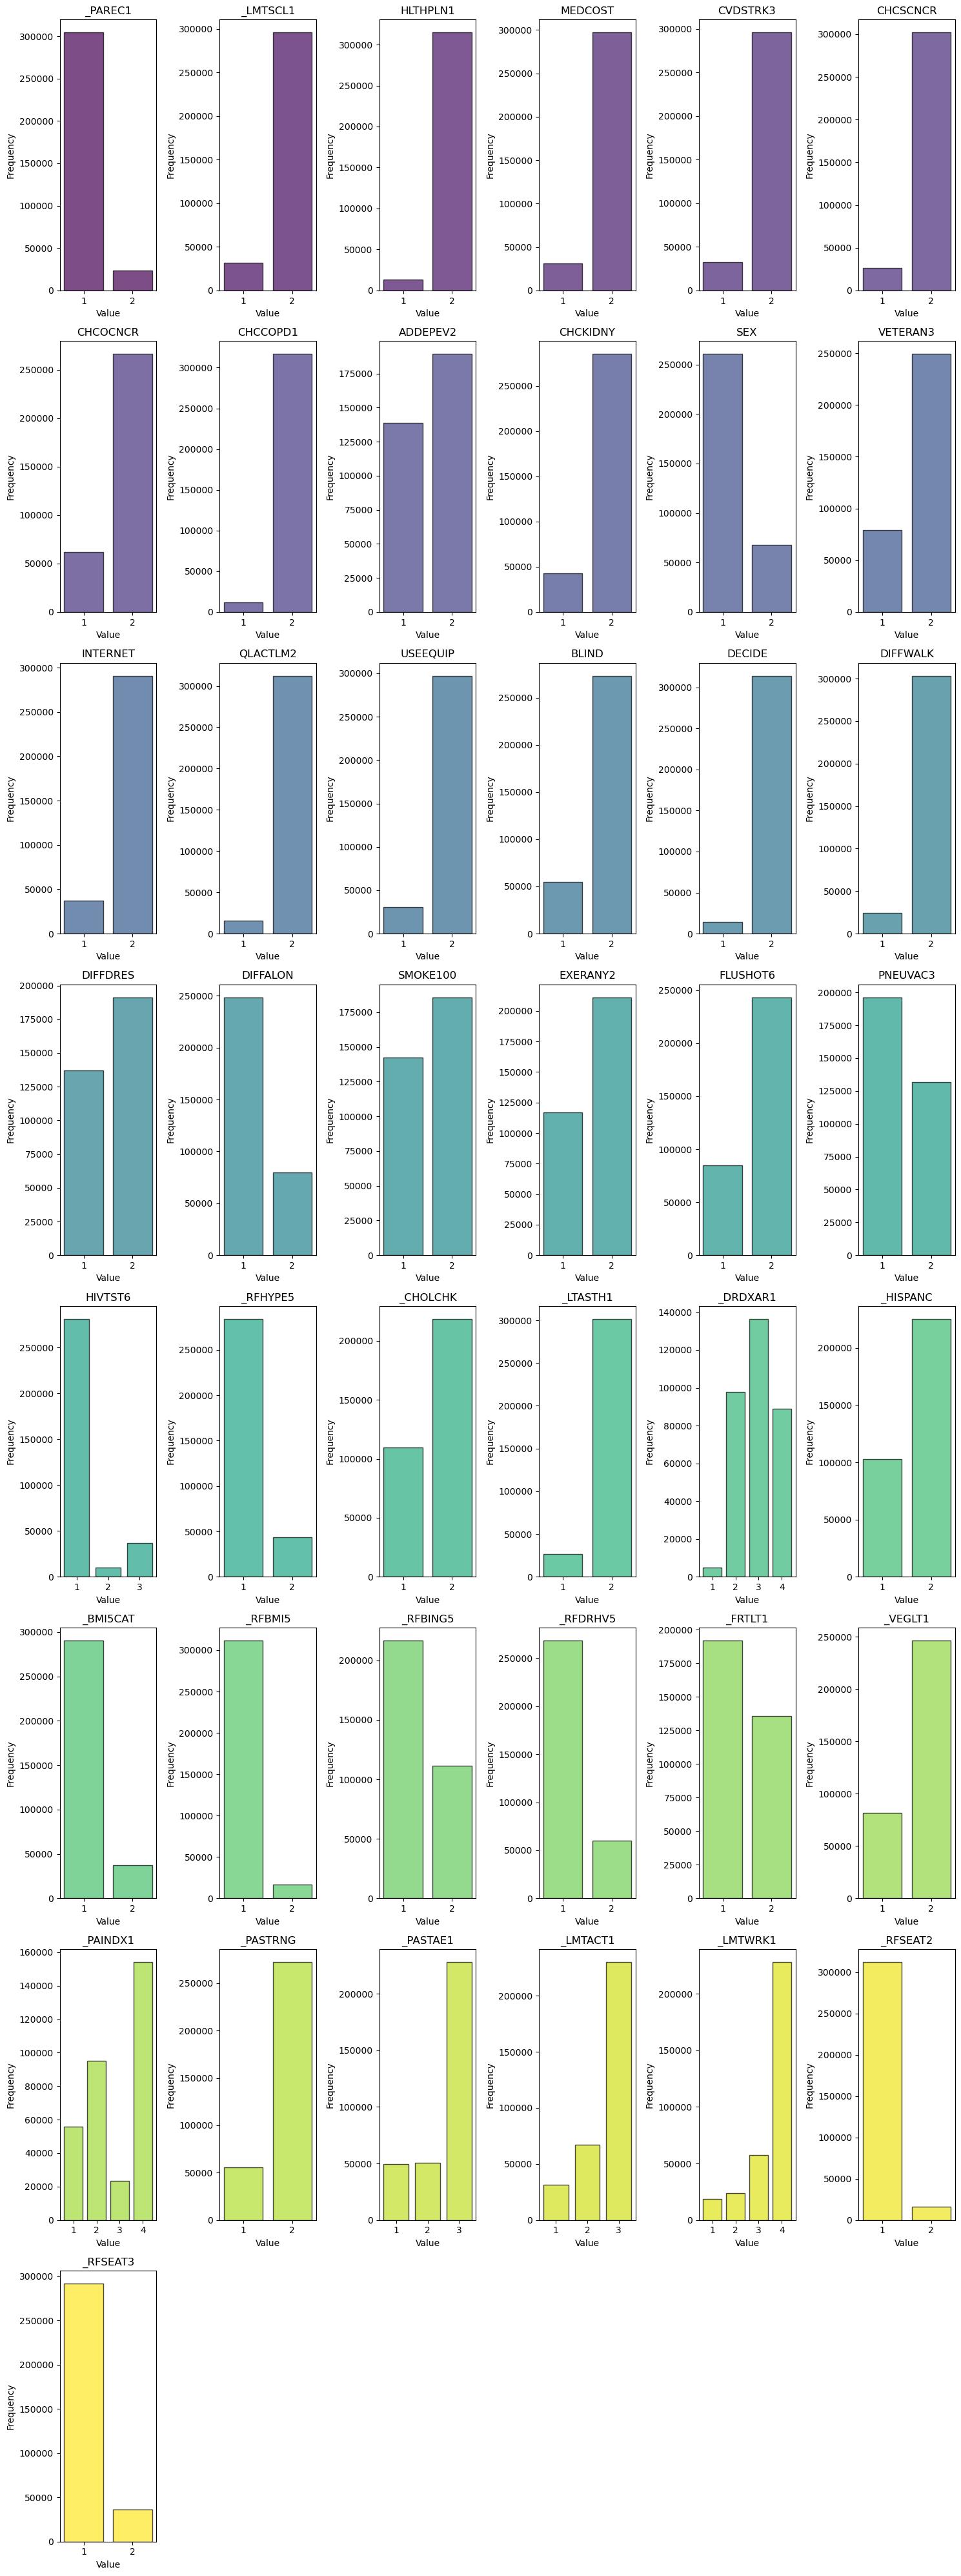

In [32]:
# Visualization of categorical features
features_list = [item for item in categorical_features[np.unique(feature_cat_map)]]
data = x_train[:, np.isin(feature_names, features_list)]
data_list = [data[:, col] for col in range(len(features_list))]
plot_histograms(data_list, features_list, num_cols=6)

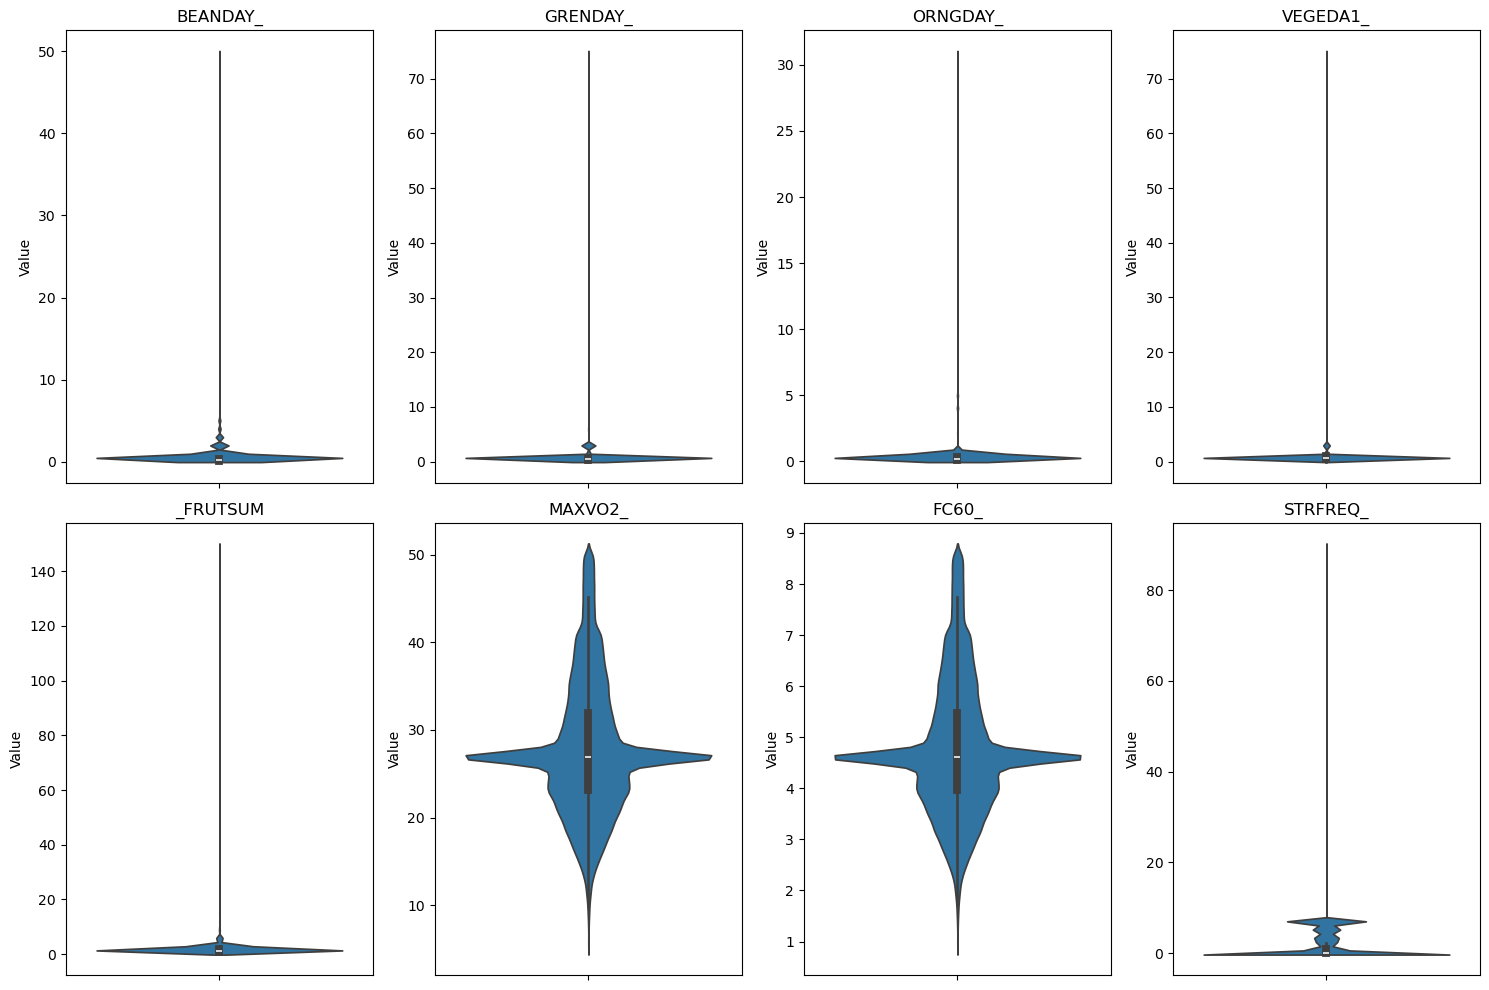

In [33]:
# Visualization of categorical features
features_list = [item for item in continuous_features[np.unique(feature_cont_map)]]
data = x_train[:, np.isin(feature_names, features_list)]
data_list = [data[:, col] for col in range(len(features_list))]
plot_violinplots(data_list, features_list, num_cols=4)

## Build model data
1. Add offset
2. Split train data into training and validation sets
3. Balance data 

In [35]:
# Add offset term
y_train, tx_train = build_model_data(y_train_processed, x_train_processed)
tx_test = np.c_[np.ones(x_test_processed.shape[0]), x_test_processed]

In [36]:
# Split data into train and validation sets
split_index = int(tx_train.shape[0] * 0.8)

np.random.seed(20)
indices = np.random.permutation(tx_train.shape[0])

# Split the indices for training and validation sets
train_indices = indices[:split_index]
validation_indices = indices[split_index:]

# Use the indices to split the data
tx_train_training = tx_train[train_indices,:]
tx_train_validation = tx_train[validation_indices,:]
y_train_training = y_train[train_indices]
y_train_validation = y_train[validation_indices]

In [37]:
# Balance data: undersample minority class
y_majority = y_train_training[y_train_training == 0]
y_minority = y_train_training[y_train_training == 1]
X_majority = tx_train_training[y_train_training.flatten() == 0, :]
X_minority = tx_train_training[y_train_training.flatten() == 1, :]

split_ratio = [0.2, 0.3, 0.35, 0.4, 0.5]
tx_training_balanced_split = []
y_training_balanced_split = []
np.random.seed(21)
for s in split_ratio:
    # Keep all minority samples and balance majority samples based on the split ratio
    desired_majority_size = int(len(y_minority) * (1 - s) / s)
    
    # Randomly select `desired_majority_size` samples from the majority class
    majority_indices = np.random.choice(len(X_majority), desired_majority_size, replace=False)
    X_majority_undersampled = X_majority[majority_indices]
    y_majority_undersampled = y_majority[majority_indices]

    # Combine the full minority class with the undersampled majority class
    tx_training_balanced = np.vstack((X_minority, X_majority_undersampled))
    y_training_balanced = np.hstack((y_minority, y_majority_undersampled)).reshape((-1, 1))

    # Store the balanced data for each split ratio
    tx_training_balanced_split.append(tx_training_balanced)
    y_training_balanced_split.append(y_training_balanced)

In [38]:
# Execute optimization algorithm, save loss and w

f1_scores = []
for idx, s in enumerate(split_ratio):

    tx_training_balanced = tx_training_balanced_split[idx]
    y_training_balanced = y_training_balanced_split[idx]
    ls_loss, ls_w = least_squares(y_training_balanced, tx_training_balanced)

    y_pred = tx_train_validation.dot(ls_w)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    f1_scores.append(f1_score)
    
    print('Least squares - Split ratio {:.2f}/{:.2f} , F1 score = {:.5f}'.format(s, 1-s, f1_score))

tx_training_balanced = tx_training_balanced_split[np.argmax(np.array(f1_scores))]
y_training_balanced = y_training_balanced_split[np.argmax(np.array(f1_scores))]

Least squares - Split ratio 0.20/0.80 , F1 score = 0.33382
Least squares - Split ratio 0.30/0.70 , F1 score = 0.38122
Least squares - Split ratio 0.35/0.65 , F1 score = 0.38401
Least squares - Split ratio 0.40/0.60 , F1 score = 0.37722
Least squares - Split ratio 0.50/0.50 , F1 score = 0.34561


## Model selection and validation

The selected models are
- Gradient Descent with MSE loss function
- Stochastic Gradient Descent with MAE loss function
- Least squares 
- Regularized least squares
- Logistic regression
- Ridge logistic regression

they are evaluated on the metrics
- loss
- accuracy
- F1-score
- MSE
- R squared

and they are optimized over
- the learning rate - _iterative algorithms (GD, SGD)_
- the penalty - _regularized algorithms (ridge regression)_
- the training / validation split ratio 

##### Initialisation of the algorithm

In [41]:
# Define the parameters of the algorithms
max_iters = 100
learning_rate = np.linspace(0.01, 0.09, 9)
penalty = np.logspace(-4, 0, 5)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))
threshold = 0.5

#### Gradient Descent - MSE loss function

In [43]:
"""Gradient descent, mse loss function"""
# Iterate over learning rate parameter values 
gd_mse_f1_score = np.zeros(len(learning_rate))
gd_mse_rmse = np.zeros(len(learning_rate))

gd_mse_ws_var_gamma = []
gd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    gd_mse_losses, gd_mse_ws = mean_squared_error_gd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("GD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(gd_mse_ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    gd_mse_f1_score[idx] = f1_score
    gd_mse_rmse[idx] = np.sqrt(mse)

    gd_mse_ws_var_gamma.append(gd_mse_ws[-1])
    gd_mse_losses_var_gamma.append(gd_mse_losses)
    

loss=0.09397112341816306
GD - mse: gamma=0.010, execution time=0.380 seconds 

loss=0.0909723107577704
GD - mse: gamma=0.020, execution time=0.263 seconds 

loss=0.08900777967449752
GD - mse: gamma=0.030, execution time=0.267 seconds 

loss=0.08767217340865616
GD - mse: gamma=0.040, execution time=0.243 seconds 

loss=0.08683569389281963
GD - mse: gamma=0.050, execution time=0.255 seconds 

loss=0.0861576115881757
GD - mse: gamma=0.060, execution time=0.240 seconds 

loss=0.08574962525730552
GD - mse: gamma=0.070, execution time=0.221 seconds 

loss=0.08536863832678052
GD - mse: gamma=0.080, execution time=0.209 seconds 

loss=0.08507930768293798
GD - mse: gamma=0.090, execution time=0.181 seconds 



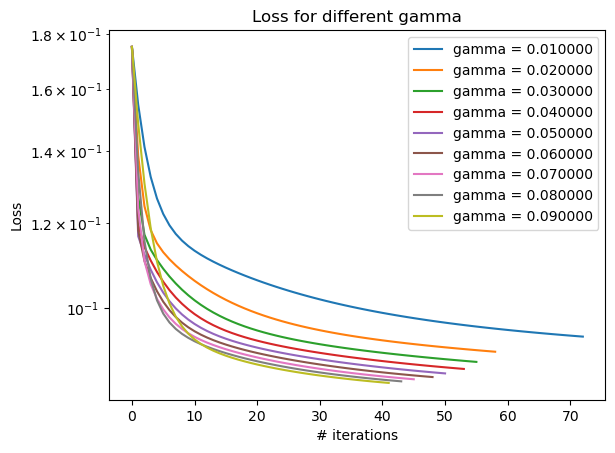

In [44]:
# Visualization
plot_loss_variable_param(gd_mse_losses_var_gamma, learning_rate, 'gamma')

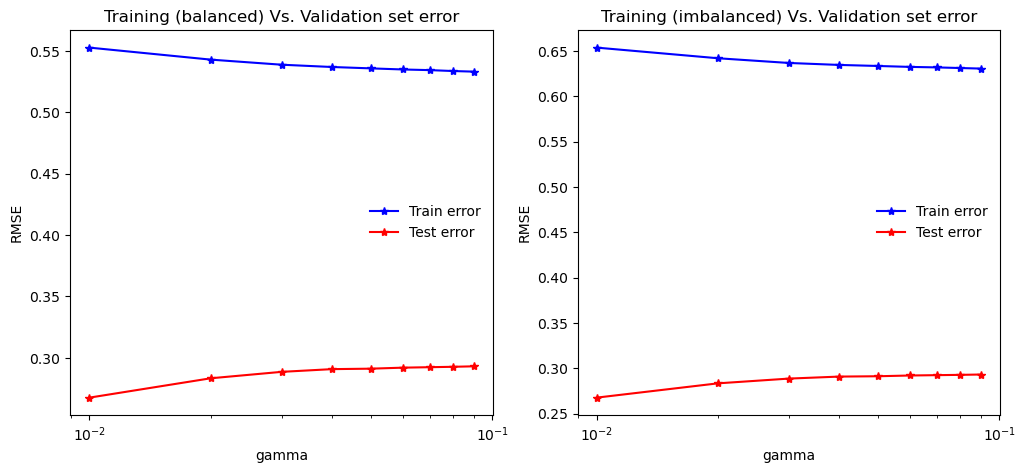

In [45]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = gd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, gd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [46]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([gd_mse_f1_score.reshape(-1,1), gd_mse_rmse.reshape(-1,1)])
metric_name = 'f1_score'

gd_mse_opt_idx = hyperparam_optimization(metric_name, metrics, gd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.090000 given optimization of the metric f1_score evaluating 0.33993.

The optimal weights are w = [[ 7.36328900e-02]
 [ 1.06392759e-02]
 [ 8.80448664e-03]
 [ 2.28515939e-02]
 [ 2.03131788e-02]
 [ 2.62067804e-03]
 [-3.33964682e-03]
 [ 1.88339332e-03]
 [ 3.18446794e-02]
 [-1.63856966e-02]
 [ 2.93598058e-02]
 [ 2.66710326e-02]
 [-2.81287081e-02]
 [-9.73784031e-04]
 [ 1.96506554e-02]
 [-5.92498693e-02]
 [-6.88280673e-04]
 [ 6.59753583e-02]
 [-6.01408037e-02]
 [-2.50634652e-02]
 [ 2.15610702e-02]
 [ 2.46965846e-03]
 [-5.08013776e-02]
 [ 2.70998802e-02]
 [ 3.36594846e-03]
 [-3.66791477e-02]
 [ 2.23058678e-02]
 [ 9.93036428e-03]
 [-4.80374174e-02]
 [ 3.29342879e-02]
 [ 1.37137819e-01]
 [-7.95220563e-03]
 [-1.38835543e-02]
 [ 4.10487829e-02]
 [-1.99087097e-02]
 [ 5.83247055e-02]
 [ 2.23804852e-02]
 [ 1.32084423e-02]
 [ 3.39380346e-02]
 [ 4.71464769e-02]
 [-9.30398465e-03]
 [-5.18457267e-03]
 [ 1.73384993e-02]
 [ 1.29847656e-02]
 [ 1.75426575e-02]
 [ 3.33247194e

In [47]:
def highly_correlated_features(w, feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, top_n):
    
    w_cat = w[1:len(feature_cat_map)+1]
    w_cont = w[len(feature_cat_map)+1:]

    sorted_indices_cat = np.argsort(w_cat)
    top_n_indices_cat = sorted_indices_cat[-top_n:]

    sorted_indices_cont = np.argsort(w_cont)
    top_n_indices_cont = sorted_indices_cont[-top_n:]

    cat_feat_idx = feature_cat_map[top_n_indices_cat]
    cont_feat_idx = feature_cont_map[top_n_indices_cont]

    correlated_cat_feat = categorical_features[cat_feat_idx]
    correlated_cont_feat = continuous_features[cont_feat_idx]

    return correlated_cat_feat, feature_cat_encoded_map[top_n_indices_cat], correlated_cont_feat

In [48]:
def highly_correlated_features(w, feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, top_n):
    
    w_cat = w[1:len(feature_cat_map)+1]
    w_cont = w[len(feature_cat_map)+1:]

    sorted_indices_cat = np.argsort(w_cat)
    top_n_indices_cat = sorted_indices_cat[-top_n:]
    top_n_weights_cat = w_cat[top_n_indices_cat]
    
    sorted_indices_cont = np.argsort(w_cont)
    top_n_indices_cont = sorted_indices_cont[-top_n:]
    top_n_weights_cont = w_cont[top_n_indices_cont]

    cat_feat_idx = feature_cat_map[top_n_indices_cat]
    cont_feat_idx = feature_cont_map[top_n_indices_cont]

    correlated_cat_feat = categorical_features[cat_feat_idx]
    correlated_cont_feat = continuous_features[cont_feat_idx]

    return correlated_cat_feat, feature_cat_encoded_map[top_n_indices_cat], top_n_weights_cat, correlated_cont_feat, top_n_weights_cont

In [49]:
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(gd_mse_ws_var_gamma[gd_mse_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))



The categorical and continuous features with higher weights are respectively 
['MEDCOST' 'HIVTST6' '_PASTRNG' '_BMI5CAT' '_LTASTH1' '_PASTAE1' '_RFBMI5'
 '_HISPANC' 'INTERNET' '_RFHYPE5'] - columns [2 2 2 4 2 2 2 2 2 2] 
and 
['FC60_' 'MAXVO2_' 'GRENDAY_' 'ORNGDAY_' '_FRUTSUM' 'VEGEDA1_' 'BEANDAY_'
 'STRFREQ_'].
The correspondend weights are respectively 
[0.03184468 0.03293429 0.03332472 0.03393803 0.04104878 0.04229536
 0.04714648 0.05832471 0.06597536 0.13713782]
and 
[-5.63309386e-02 -5.62020336e-02 -8.89561505e-03 -2.48480930e-03
 -1.31282758e-05 -8.76769728e-06  4.17744717e-03  2.00886163e-02].


#### Stochastic gradient descent - MSE loss function

In [51]:
"""Stochastic gradient descent, mse loss function"""
# Iterate over learning rate parameter values 

learning_rate = np.linspace(0.001, 0.1, 10)

sgd_mse_f1_score = np.zeros(len(learning_rate))
sgd_mse_rmse = np.zeros(len(learning_rate))

sgd_mse_ws_var_gamma = []
sgd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    losses, ws = mean_squared_error_sgd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("SGD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)

    print(f1_score)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    sgd_mse_f1_score[idx] = f1_score
    sgd_mse_rmse[idx] = np.sqrt(mse)

    sgd_mse_ws_var_gamma.append(ws[-1])
    sgd_mse_losses_var_gamma.append(losses)
    

loss=0.04822679149276499
SGD - mse: gamma=0.001, execution time=0.008 seconds 

0.0
loss=0.02443250545127626
SGD - mse: gamma=0.012, execution time=0.002 seconds 

0.06297953964194374
loss=0.09357669338959274
SGD - mse: gamma=0.023, execution time=0.008 seconds 

0.28898377455166524
loss=0.3265295031271134
SGD - mse: gamma=0.034, execution time=0.008 seconds 

0.3314327754276255
loss=0.305462424132366
SGD - mse: gamma=0.045, execution time=0.007 seconds 

0.20912145580850983
loss=0.42991094683965475
SGD - mse: gamma=0.056, execution time=0.002 seconds 

0.01874254557846311
loss=0.07962738648593326
SGD - mse: gamma=0.067, execution time=0.004 seconds 

0.1980791040544372
loss=0.28656261127026594
SGD - mse: gamma=0.078, execution time=0.004 seconds 

0.1367170309520317
loss=0.28880919108229736
SGD - mse: gamma=0.089, execution time=0.008 seconds 

0.27183346149621
loss=111.96211860529735
SGD - mse: gamma=0.100, execution time=0.008 seconds 

0.16065720854595414


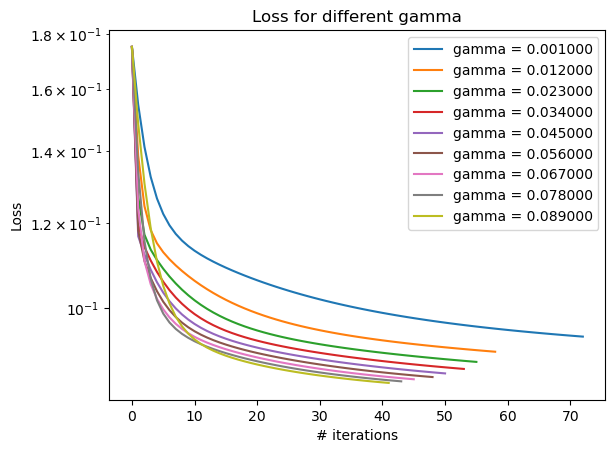

In [52]:
# Visualization
plot_loss_variable_param(gd_mse_losses_var_gamma, learning_rate, 'gamma')

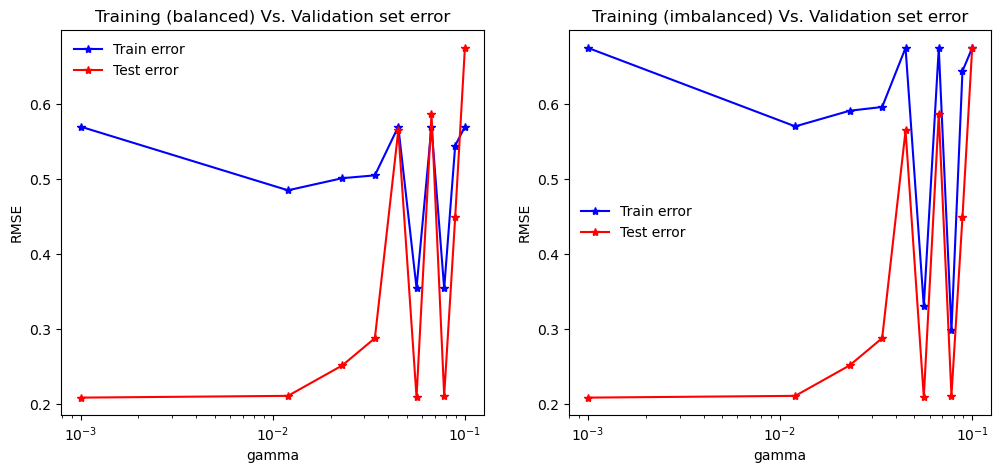

In [53]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = sgd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, sgd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [54]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([sgd_mse_f1_score.reshape(-1,1), sgd_mse_rmse.reshape(-1,1)])
metric_name = 'f1_score'

sgd_mse_opt_idx = hyperparam_optimization(metric_name, metrics, sgd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.034000 given optimization of the metric f1_score evaluating 0.33143.

The optimal weights are w = [[ 6.64195925e-02]
 [ 7.91826162e-03]
 [ 1.18261621e-02]
 [ 1.94784234e-02]
 [ 2.59126357e-02]
 [ 8.77955621e-03]
 [-1.09069320e-02]
 [-1.05812028e-03]
 [ 3.49577503e-02]
 [-1.84442034e-02]
 [ 2.45834201e-02]
 [ 2.68050393e-02]
 [-2.52781713e-02]
 [ 1.00001188e-02]
 [ 1.70169935e-02]
 [-5.63137036e-02]
 [-9.80708039e-03]
 [ 5.65702190e-02]
 [-7.21737774e-02]
 [-2.87294845e-02]
 [ 2.73622913e-02]
 [-5.22495378e-05]
 [-5.21934050e-02]
 [ 2.67090377e-02]
 [ 6.01671939e-03]
 [-4.49461809e-02]
 [ 2.98302959e-02]
 [ 1.13351270e-02]
 [-4.00507397e-02]
 [ 2.82980393e-02]
 [ 1.30706699e-01]
 [-1.25985972e-02]
 [-1.45663371e-02]
 [ 2.85184327e-02]
 [-2.31339292e-02]
 [ 6.27648766e-02]
 [ 2.13409722e-02]
 [ 1.67192439e-02]
 [ 2.30592388e-02]
 [ 3.97784827e-02]
 [-1.61207068e-03]
 [-3.15166231e-03]
 [ 1.84665713e-02]
 [ 4.35313732e-03]
 [ 3.47766517e-02]
 [ 2.88890443e

In [55]:
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(sgd_mse_ws_var_gamma[sgd_mse_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))


The categorical and continuous features with higher weights are respectively 
['_LTASTH1' '_PASTRNG' 'EXERANY2' '_PAINDX1' 'MEDCOST' '_PASTAE1'
 '_RFBMI5' 'INTERNET' '_HISPANC' '_RFHYPE5'] - columns [2 2 2 2 2 2 2 2 2 2] 
and 
['FC60_' 'MAXVO2_' 'GRENDAY_' 'VEGEDA1_' 'BEANDAY_' '_FRUTSUM' 'ORNGDAY_'
 'STRFREQ_'].
The correspondend weights are respectively 
[0.02851843 0.02888904 0.0298303  0.03477665 0.03495775 0.03922285
 0.03977848 0.05657022 0.06276488 0.1307067 ]
and 
[-0.07109423 -0.07097336 -0.02055774 -0.00731675 -0.00173985  0.00129081
  0.00324536  0.01037446].


#### Least squares

In [57]:
"""Least squares"""

# Execute optimization algorithm, save loss and w
start_time = datetime.datetime.now()
ls_loss, ls_w = least_squares(y_training_balanced, tx_training_balanced)
end_time = datetime.datetime.now()

# Print execution time 
execution_time = (end_time - start_time).total_seconds()
print("Least squares: execution time={t:.3f} seconds.\n\n".format(t=execution_time))

# Compute accuracy metrics
y_pred = tx_train_validation.dot(ls_w)
y_pred = np.where(y_pred > threshold, 1, 0)

tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
f1_score = 2*tp/(2*tp + fp + fn)
rmse = np.sqrt(calculate_mse(y_train_validation - y_pred))

print('The optimal weights are w = {}\n.'.format(ls_w))
print('f1 score = {f:.5f}, RMSE = {r:.5f}\n'.format(f=f1_score, r=rmse))
print('*******************************\n')
print_report(ls_w, False, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)


Least squares: execution time=0.032 seconds.


The optimal weights are w = [[ 1.12389048e+00]
 [-3.96852319e+01]
 [-3.96210107e+01]
 [-3.96635818e+01]
 [-1.02045532e-02]
 [-2.63584574e-02]
 [ 7.07062907e-02]
 [-8.47894746e-03]
 [-2.61993604e-02]
 [-2.09061593e-01]
 [-2.56775782e-02]
 [-2.00829031e-02]
 [-1.35372967e-01]
 [-1.91016988e-02]
 [-1.15909831e-01]
 [-1.26934034e-01]
 [-3.27501946e-02]
 [ 5.17767719e-02]
 [-5.40897812e-02]
 [-3.60136827e-02]
 [-5.84076513e-02]
 [-2.42986031e-02]
 [-6.13790266e-02]
 [ 1.98757006e-02]
 [-5.59177708e-03]
 [-4.46801693e-02]
 [ 4.35008377e-03]
 [ 2.25006466e-04]
 [-8.05365904e-02]
 [ 1.70167672e-02]
 [ 1.38692069e-01]
 [-7.27538885e-02]
 [-5.13261986e-02]
 [ 9.29970717e-03]
 [-8.45540299e-02]
 [-2.43379962e-02]
 [-5.69154605e-03]
 [ 3.24754706e+00]
 [ 3.25318911e+00]
 [-3.24914697e+00]
 [-3.92239473e-02]
 [-3.06632326e-02]
 [-2.01564048e-03]
 [-4.31091948e-04]
 [-1.70773648e-02]
 [ 5.34314298e-02]
 [ 3.96471228e+01]
 [ 1.57140046e-02]
 [-2.95260870

In [58]:
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(ls_w.flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))


The categorical and continuous features with higher weights are respectively 
['_LMTACT1' 'HIVTST6' 'DIFFDRES' 'INTERNET' '_PASTRNG' '_LMTSCL1'
 '_RFHYPE5' '_BMI5CAT' '_BMI5CAT' '_PASTAE1'] - columns [2 2 2 2 2 4 2 3 4 2] 
and 
['FC60_' 'GRENDAY_' '_FRUTSUM' 'ORNGDAY_' 'VEGEDA1_' 'BEANDAY_' 'STRFREQ_'
 'MAXVO2_'].
The correspondend weights are respectively 
[1.57140046e-02 1.70167672e-02 1.98757006e-02 5.17767719e-02
 5.34314298e-02 7.07062907e-02 1.38692069e-01 3.24754706e+00
 3.25318911e+00 3.96471228e+01]
and 
[-1.06015008e+00 -3.82835232e-03 -3.38999002e-03 -1.76943365e-03
  7.18248334e-04  1.66514974e-03  2.72339419e-03  9.82988270e-01].


#### Ridge regression

In [60]:
"""Ridge regression"""

# Iterate over penalty parameter values
ridge_ls_loss = np.zeros(len(penalty))
ridge_ls_f1_score = np.zeros(len(penalty))
ridge_ls_rmse = np.zeros(len(penalty))

ridge_ls_ws_var_lambda = []

for idx, lambda_ in enumerate(penalty):

    # Execute optimization algorithm, save w 
    start_time = datetime.datetime.now()
    ridge_ls_losses, ridge_ls_ws = ridge_regression(y_training_balanced, tx_training_balanced, lambda_)
    end_time = datetime.datetime.now()

    # Print execution time 
    execution_time = (end_time - start_time).total_seconds()
    print("Ridge regression: lambda={l:.3f}, execution time={t:.3f} seconds \n".format(l=lambda_, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ridge_ls_ws)
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    ridge_ls_loss[idx] = ridge_ls_losses
    ridge_ls_f1_score[idx] = f1_score
    ridge_ls_rmse[idx] = np.sqrt(mse)

    ridge_ls_ws_var_lambda.append(ridge_ls_ws)
    

Ridge regression: lambda=0.000, execution time=0.020 seconds 

Ridge regression: lambda=0.001, execution time=0.032 seconds 

Ridge regression: lambda=0.010, execution time=0.025 seconds 

Ridge regression: lambda=0.100, execution time=0.015 seconds 

Ridge regression: lambda=1.000, execution time=0.022 seconds 



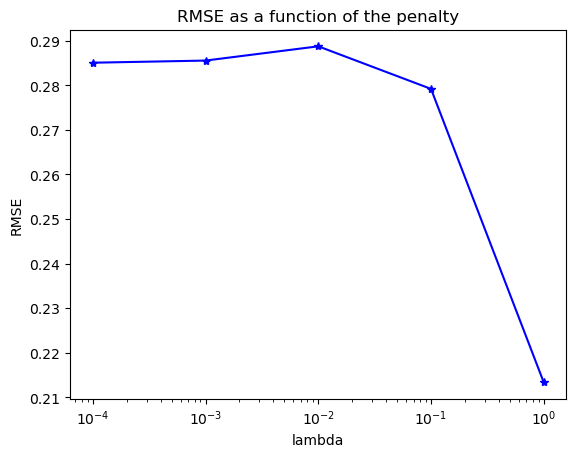

In [61]:
fig = plt.figure()
plt.semilogx(penalty, ridge_ls_rmse, color="b", marker="*")
plt.title("RMSE as a function of the penalty")
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.show()

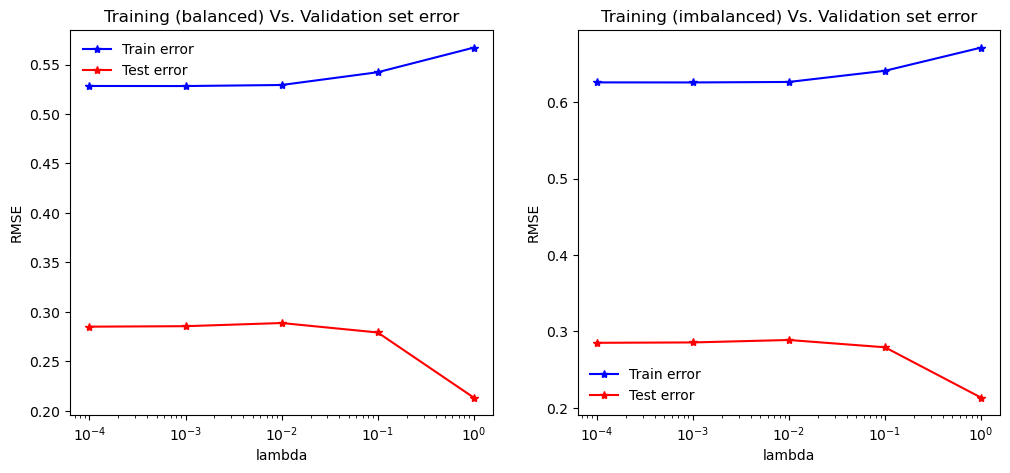

In [62]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = ridge_ls_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, ridge_ls_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

In [63]:
metrics = np.hstack([ridge_ls_f1_score.reshape(-1,1), ridge_ls_rmse.reshape(-1,1)])
metric_name = 'f1_score'

ridge_ls_opt_idx = hyperparam_optimization(metric_name, metrics, ridge_ls_ws_var_lambda, penalty, 'lambda', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is lambda=0.001000 given optimization of the metric f1_score evaluating 0.38345.

The optimal weights are w = [[ 8.47178190e-01]
 [-1.95594460e-02]
 [ 2.70776041e-02]
 [ 9.37664608e-04]
 [ 2.34252099e-04]
 [-1.73039683e-02]
 [ 5.62971455e-02]
 [-1.62206002e-03]
 [-1.35151662e-02]
 [-1.88605133e-01]
 [-1.32333781e-02]
 [-9.40324301e-03]
 [-1.24690213e-01]
 [-1.83175799e-02]
 [-8.94959322e-02]
 [-1.22860599e-01]
 [-2.44892599e-02]
 [ 5.93544704e-02]
 [-5.95822300e-02]
 [-3.55160141e-02]
 [-4.09808963e-02]
 [-2.19584569e-02]
 [-6.44898825e-02]
 [ 3.35351026e-02]
 [-5.54505749e-03]
 [-4.41004450e-02]
 [ 7.11927394e-03]
 [ 3.50366484e-03]
 [-7.91285654e-02]
 [ 1.94407299e-02]
 [ 1.45724218e-01]
 [-6.74029110e-02]
 [-4.67304223e-02]
 [ 1.90817292e-02]
 [-8.02542603e-02]
 [ 2.31306969e-03]
 [ 8.45355691e-02]
 [ 2.77563893e-02]
 [ 3.36974198e-02]
 [ 6.14538091e-02]
 [-3.77471714e-02]
 [-2.86808201e-02]
 [ 9.64502353e-04]
 [ 1.33939168e-03]
 [-1.50977501e-02]
 [ 4.21141894

In [64]:
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(ridge_ls_ws_var_lambda[ridge_ls_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))


The categorical and continuous features with higher weights are respectively 
['_PAREC1' '_BMI5CAT' 'DIFFDRES' '_BMI5CAT' '_PASTRNG' '_LMTSCL1'
 'INTERNET' '_RFBMI5' '_BMI5CAT' '_RFHYPE5'] - columns [3 3 2 4 2 4 2 2 2 2] 
and 
['FC60_' 'MAXVO2_' 'GRENDAY_' '_FRUTSUM' 'ORNGDAY_' 'VEGEDA1_' 'BEANDAY_'
 'STRFREQ_'].
The correspondend weights are respectively 
[0.0270776  0.02775639 0.0335351  0.03369742 0.04211419 0.05629715
 0.05935447 0.06145381 0.08453557 0.14572422]
and 
[-0.04150133 -0.03750527 -0.00381996 -0.00270368 -0.00173626  0.00054586
  0.00242508  0.00616444].


#### Logistic regression

In [66]:
### AAA: Balance data

In [67]:
# Define the parameters of the algorithms
max_iters = 100
learning_rate = np.logspace(-4, -1, 4)
penalty = np.logspace(-6, 0, 7)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))
threshold = 0

In [68]:
"""Logistic regression - gradient descent"""
# Iterate over learning rate parameter values 
logistic_gd_f1_score = np.zeros(len(learning_rate))
logistic_gd_rmse = np.zeros(len(learning_rate))

logistic_gd_ws_var_gamma = []
logistic_gd_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and w at every iteration
    start_time = datetime.datetime.now()
    logistic_gd_losses, logistic_gd_ws = logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("Logistic regression - Gradient descent: gamma={g:.4f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(logistic_gd_ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    logistic_gd_f1_score[idx] = f1_score
    logistic_gd_rmse[idx] = np.sqrt(mse)

    logistic_gd_ws_var_gamma.append(logistic_gd_ws[-1])
    logistic_gd_losses_var_gamma.append(logistic_gd_losses)

loss=0.6930787904480723
Logistic regression - Gradient descent: gamma=0.0001, execution time=0.021 seconds 

loss=0.6472438033995562
Logistic regression - Gradient descent: gamma=0.0010, execution time=0.667 seconds 

loss=0.5711805113844102
Logistic regression - Gradient descent: gamma=0.0100, execution time=0.631 seconds 

loss=0.4971638370693271
Logistic regression - Gradient descent: gamma=0.1000, execution time=0.709 seconds 



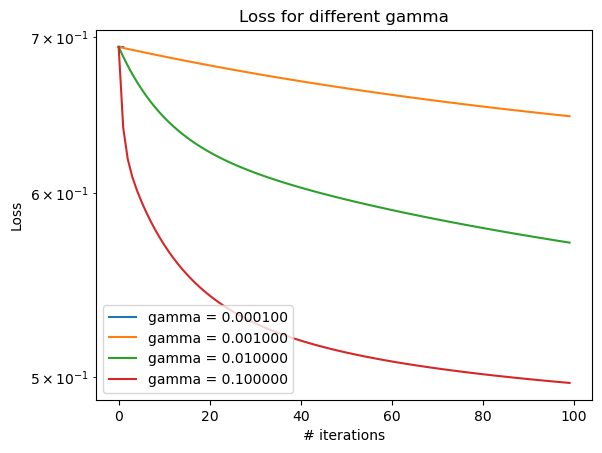

In [69]:
# Visualization
plot_loss_variable_param(logistic_gd_losses_var_gamma, learning_rate, 'gamma')

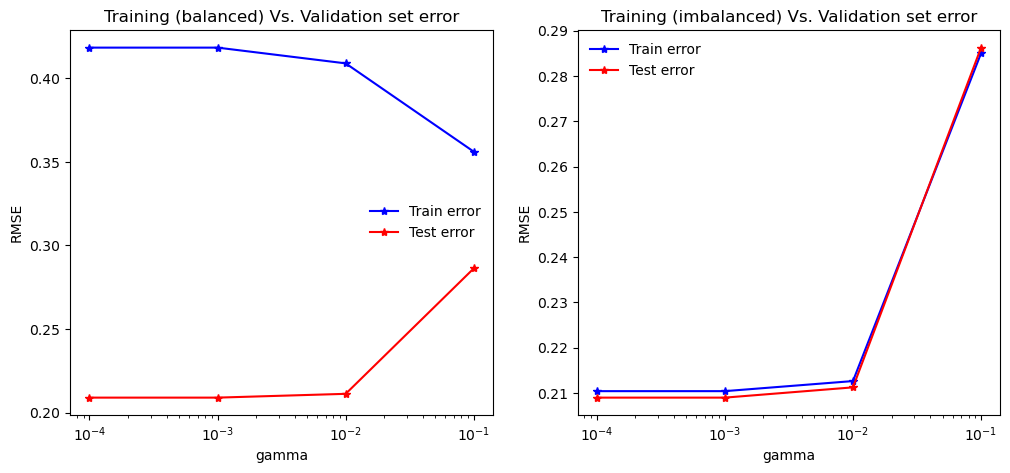

In [70]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = logistic_gd_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, logistic_gd_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [71]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([logistic_gd_f1_score.reshape(-1,1), logistic_gd_rmse.reshape(-1,1)])
metric_name = 'f1_score'

logistic_gd_opt_idx = hyperparam_optimization(metric_name, metrics, logistic_gd_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, True)

The optimal parameter is gamma=0.100000 given optimization of the metric f1_score evaluating 0.35078.

The optimal weights are w = [[ 0.05698629]
 [-0.00546884]
 [ 0.00627366]
 [ 0.06801124]
 [ 0.03987584]
 [-0.00578986]
 [-0.07601154]
 [-0.01451483]
 [-0.00340715]
 [-0.15201077]
 [-0.01888269]
 [-0.02479393]
 [-0.17397703]
 [-0.06820871]
 [-0.0594437 ]
 [-0.21890803]
 [-0.10004985]
 [ 0.18374844]
 [-0.22658106]
 [-0.14341914]
 [-0.04389237]
 [-0.07155634]
 [-0.21083922]
 [-0.02378218]
 [-0.07086338]
 [-0.17427356]
 [ 0.07180051]
 [-0.02785614]
 [-0.2096467 ]
 [ 0.05701495]
 [ 0.41747166]
 [-0.02666039]
 [-0.08341704]
 [ 0.08530121]
 [-0.12224803]
 [ 0.05694075]
 [-0.04852463]
 [ 0.00959258]
 [ 0.09429149]
 [ 0.10388407]
 [-0.05384899]
 [-0.02104606]
 [ 0.02762151]
 [ 0.02538275]
 [ 0.04266423]
 [ 0.06239874]
 [ 0.06881607]
 [ 0.00155321]
 [-0.08230954]
 [ 0.0276586 ]
 [-0.07259032]
 [ 0.02717689]
 [ 0.03244028]
 [ 0.00265693]
 [-0.06867765]
 [-0.02818048]
 [-0.01635407]
 [-0.03284624]

In [72]:
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(logistic_gd_ws_var_gamma[logistic_gd_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))


The categorical and continuous features with higher weights are respectively 
['HIVTST6' '_PASTRNG' '_PAREC1' '_PASTAE1' 'EXERANY2' '_LTASTH1'
 '_BMI5CAT' '_RFBMI5' 'INTERNET' '_RFHYPE5'] - columns [2 2 4 2 2 2 4 2 2 2] 
and 
['FC60_' 'MAXVO2_' 'GRENDAY_' '_FRUTSUM' 'ORNGDAY_' 'STRFREQ_' 'VEGEDA1_'
 'BEANDAY_'].
The correspondend weights are respectively 
[0.05701495 0.06239874 0.06801124 0.06881607 0.07180051 0.08530121
 0.09429149 0.10388407 0.18374844 0.41747166]
and 
[-0.36997905 -0.36970044 -0.06867765 -0.03284624 -0.02818048 -0.02196176
 -0.01635407  0.00265693].


#### Regularized Logistic Regression 

In [74]:
"""Regularized logistic regression"""

# Iterate over penalty parameter values 
reg_lr_f1_score = np.zeros((len(penalty), len(learning_rate)))
reg_lr_rmse = np.zeros((len(penalty), len(learning_rate)))

reg_lr_ws_var_lambda_and_gamma = []
reg_lr_losses_var_lambda_and_gamma = []

for idx_l, lambda_ in enumerate(penalty):

    for idx_g, gamma in enumerate(learning_rate):
    
        # Execute optimization algorithm, save losses and w at every iteration
        start_time = datetime.datetime.now()
        reg_logistic_losses, reg_logistic_ws = reg_logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma, lambda_)
        end_time = datetime.datetime.now()
        
        # Print excecution time
        execution_time = (end_time - start_time).total_seconds()
        print("Regularized logistic regression: gamma={g:.4f}, lambda={l:.6f}, execution time={t:.3f} seconds \n".format(g=gamma, l= lambda_, t=execution_time))
    
        # Compute accuracy metrics
        y_pred = tx_train_validation.dot(reg_logistic_ws[-1])
        y_pred = np.where(y_pred > threshold, 1, 0)
    
        tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
        f1_score = 2*tp/(2*tp + fp + fn)
        mse = calculate_mse(y_train_validation - y_pred)
        
        # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
        reg_lr_f1_score[idx_l, idx_g] = f1_score
        reg_lr_rmse[idx_l, idx_g] = np.sqrt(mse)
    
        reg_lr_ws_var_lambda_and_gamma.append(reg_logistic_ws[-1].flatten())
        reg_lr_losses_var_lambda_and_gamma.append(reg_logistic_losses)

loss=0.6866609625620532
Regularized logistic regression: gamma=0.0001, lambda=0.000001, execution time=0.621 seconds 

loss=0.6472438112550344
Regularized logistic regression: gamma=0.0010, lambda=0.000001, execution time=0.658 seconds 

loss=0.5711806447645689
Regularized logistic regression: gamma=0.0100, lambda=0.000001, execution time=0.640 seconds 

loss=0.4971650318867232
Regularized logistic regression: gamma=0.1000, lambda=0.000001, execution time=0.629 seconds 

loss=0.6866609636957649
Regularized logistic regression: gamma=0.0001, lambda=0.000010, execution time=0.629 seconds 

loss=0.6472438819542211
Regularized logistic regression: gamma=0.0010, lambda=0.000010, execution time=0.630 seconds 

loss=0.5711818451727604
Regularized logistic regression: gamma=0.0100, lambda=0.000010, execution time=0.624 seconds 

loss=0.49717578419929476
Regularized logistic regression: gamma=0.1000, lambda=0.000010, execution time=0.656 seconds 

loss=0.6866609750328975
Regularized logistic re

In [75]:
reg_lr_ws_var_lambda_and_gamma = np.reshape(reg_lr_ws_var_lambda_and_gamma, (len(penalty), len(learning_rate), len(w_initial)))
reg_lr_losses_var_lambda_and_gamma = np.reshape(reg_lr_losses_var_lambda_and_gamma, (len(penalty), len(learning_rate), max_iters))

In [76]:
# Get optimal parameter and corresponding model weights, apply to test set
metric_name = 'f1_score'
if metric_name == 'f1_score':
    metric = reg_lr_f1_score
    opt_index = np.argmax(reg_lr_f1_score)
elif metric_name == 'RMSE':
    metric = reg_lr_rmse
    opt_index = np.argmin(reg_lr_rmse)

# Convert this index to row and column indices
opt_row, opt_col = np.unravel_index(opt_index, metric.shape)

opt_lambda = penalty[opt_row]
opt_gamma = learning_rate[opt_col]
opt_w = reg_lr_ws_var_lambda_and_gamma[opt_row, opt_col]
opt_metric = metric[opt_row, opt_col]

print('The optimal parameters are lambda ={l:.6f} and gamma = {g:.6f} given optimization of the metric {metr} evaluating {m:.5f}.'.format(l = opt_lambda, g=opt_gamma, metr=metric_name, m=opt_metric))
print('The optimal weights are w = {}.'.format(opt_w))
print('f1 score = {f:.5f}, RMSE = {r:.5f}\n'.format(f=reg_lr_f1_score[opt_row, opt_col], r=reg_lr_rmse[opt_row, opt_col]))
print('*******************************\n')

print_report(opt_w, True, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)

The optimal parameters are lambda =0.000100 and gamma = 0.100000 given optimization of the metric f1_score evaluating 0.35086.
The optimal weights are w = [ 0.05691338 -0.00547296  0.00626505  0.06795528  0.03984984 -0.00576815
 -0.07599911 -0.01450855 -0.00341577 -0.1518921  -0.01889385 -0.02479892
 -0.17384449 -0.06816221 -0.05941155 -0.2187125  -0.09998914  0.1836056
 -0.22641448 -0.1433317  -0.04387491 -0.07151315 -0.21069415 -0.02378731
 -0.07082932 -0.17413617  0.07175466 -0.02786301 -0.20950541  0.05696282
  0.41711    -0.02663749 -0.08334587  0.08522313 -0.12219092  0.05687468
 -0.0484946   0.00957497  0.09420816  0.10378313 -0.0538079  -0.02102902
  0.02759394  0.02536493  0.04263764  0.06233918  0.06874737  0.0015641
 -0.08229119  0.02765758 -0.07257957  0.02715215  0.03240965  0.00264344
 -0.06864065 -0.02816397 -0.01635401 -0.0328269  -0.36946314 -0.36974147
 -0.02196417].
f1 score = 0.35086, RMSE = 0.28623

*******************************

-----------True Vs. Predicted pos

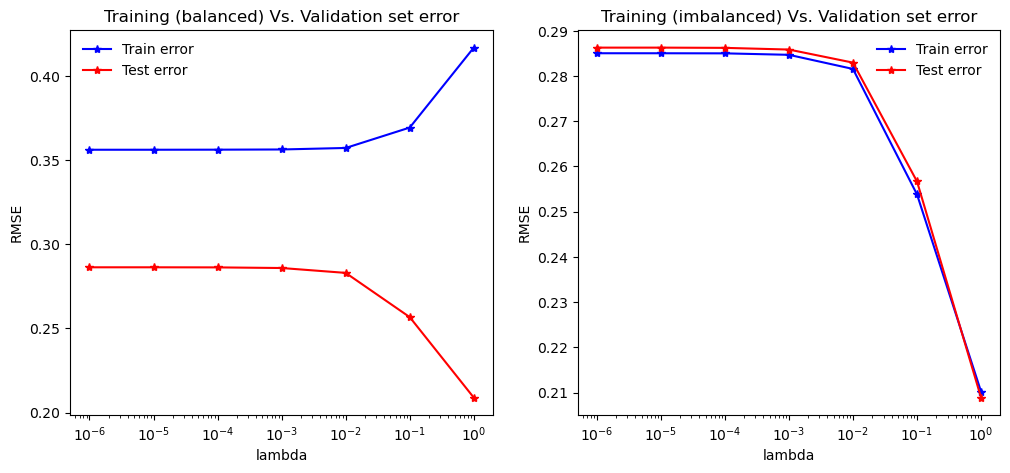

In [77]:
# Training (balanced) Vs. Validation error - penalty
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_lambda = [reg_lr_ws_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[0])]
rmse_validation = reg_lr_rmse[:,opt_col]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

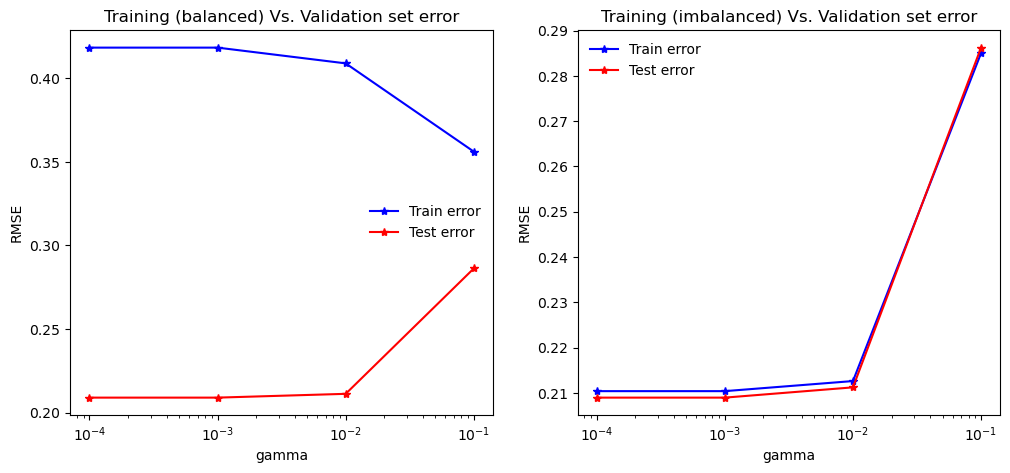

In [78]:
# Training (balanced) Vs. Validation error - learning rate
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_gamma = [reg_lr_ws_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[1])]
rmse_validation = reg_lr_rmse[opt_row, :]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

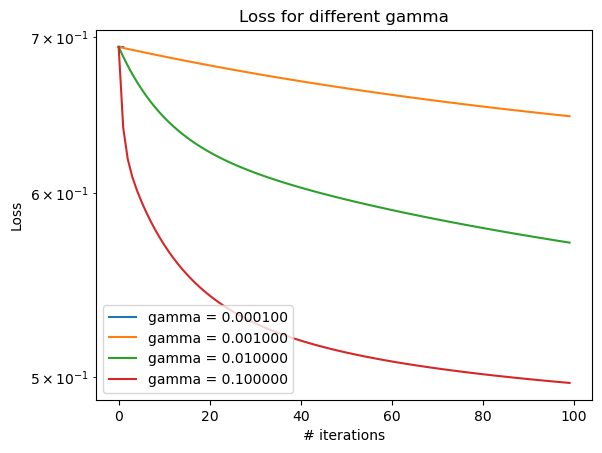

In [79]:
# Visualization
reg_lr_losses_var_gamma =  [reg_lr_losses_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_losses_var_lambda_and_gamma)[1])]
plot_loss_variable_param(logistic_gd_losses_var_gamma, learning_rate, 'gamma')

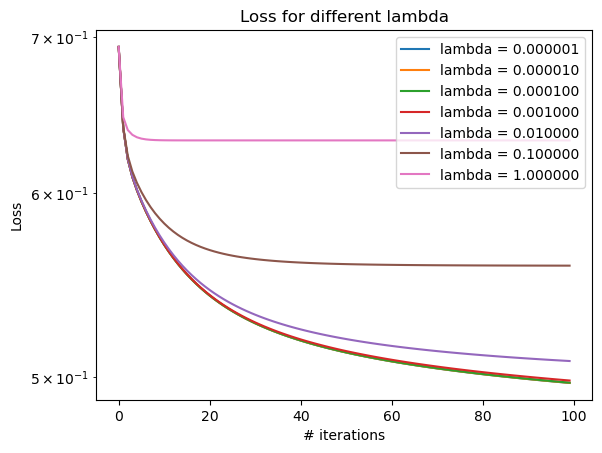

In [80]:
# Visualization
reg_lr_losses_var_lambda = [reg_lr_losses_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_losses_var_lambda_and_gamma)[0])]
plot_loss_variable_param(reg_lr_losses_var_lambda, penalty, 'lambda')

In [81]:
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(opt_w.flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))

The categorical and continuous features with higher weights are respectively 
['HIVTST6' '_PASTRNG' '_PAREC1' '_PASTAE1' 'EXERANY2' '_LTASTH1'
 '_BMI5CAT' '_RFBMI5' 'INTERNET' '_RFHYPE5'] - columns [2 2 4 2 2 2 4 2 2 2] 
and 
['FC60_' 'MAXVO2_' 'GRENDAY_' '_FRUTSUM' 'ORNGDAY_' 'STRFREQ_' 'VEGEDA1_'
 'BEANDAY_'].
The correspondend weights are respectively 
[0.05696282 0.06233918 0.06795528 0.06874737 0.07175466 0.08522313
 0.09420816 0.10378313 0.1836056  0.41711   ]
and 
[-0.36974147 -0.36946314 -0.06864065 -0.0328269  -0.02816397 -0.02196417
 -0.01635401  0.00264344].


In [82]:
'''
# features_to_keep = [
'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
'PERSDOC2', 'MEDCOST', 'CHECKUP1',
'CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 
'SEX', 'MARITAL', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'INTERNET', 
'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 
'SMOKE100', 
'EXERANY2',
'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 
'_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_DRDXAR1', 
'_MRACE1', '_HISPANC', '_RACEGR3', 
'_AGE80',
'HTM4', 
'WTKG3', '_BMI5CAT','_RFBMI5', 
'_CHLDCNT', '_EDUCAG', '_INCOMG', 
'_SMOKER3', 
'DROCDY3_', '_RFBING5','_RFDRHV5', 
'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_','ORNGDAY_', 'VEGEDA1_','_FRUTSUM', '_FRTLT1', '_VEGLT1', 
'_TOTINDA', 'MAXVO2_', 'FC60_', 
'STRFREQ_', '_PACAT1', '_PAINDX1', '_PASTRNG', '_PAREC1', '_PASTAE1', 
'_LMTACT1','_LMTWRK1', '_LMTSCL1', 
'_RFSEAT2', '_RFSEAT3', 
'_AIDTST3']
'''

"\n# features_to_keep = [\n'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',\n'PERSDOC2', 'MEDCOST', 'CHECKUP1',\n'CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',\n'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', \n'SEX', 'MARITAL', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'INTERNET', \n'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', \n'SMOKE100', \n'EXERANY2',\n'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', \n'_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_DRDXAR1', \n'_MRACE1', '_HISPANC', '_RACEGR3', \n'_AGE80',\n'HTM4', \n'WTKG3', '_BMI5CAT','_RFBMI5', \n'_CHLDCNT', '_EDUCAG', '_INCOMG', \n'_SMOKER3', \n'DROCDY3_', '_RFBING5','_RFDRHV5', \n'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_','ORNGDAY_', 'VEGEDA1_','_FRUTSUM', '_FRTLT1', '_VEGLT1', \n'_TOTINDA', 'MAXVO2_', 'FC60_', \n'STRFREQ_', '_PACAT1', '_PAINDX1', '_PASTRNG', '_PAREC1', '_PASTAE1', \n'_LMTACT1','_LMTWRK1', '_LMTSCL1', \n'_RFSEAT2', '_RFSEAT3', \n'_AIDTST3']\n"